In [ ]:
from joblib import Memory
memory = Memory(location="./results_cache")

In [ ]:
pi = "3.14159265358979323846264338327950288419716939937510582097494459230781640628620899862803482534211706798214808651328230664709384460955058223172535940812848111745028410270193852110555964462294895493038196442881097566593344612847564823378678316527120190914564856692346034861045432664821339360726024914127372458700660631558817488152092096282925409171536436789259036001133053054882046652138414695194151160943305727036575959195309218611738193261179310511854807446237996274956735188575272489122793818301194912983367336244065664308602139494639522473719070217986094370277053921717629317675238467481846766940513200056812714526356082778577134275778960917363717872146844090122495343014654958537105079227968925892354201995611212902196086403441815981362977477130996051870721134999999837297804995105973173281609631859502445945534690830264252230825334468503526193118817101000313783875288658753320838142061717766914730359825349042875546873115956286388235378759375195778185778053217122680661300192787661119590921642019893809525720106548586327886593615338182796823030195203530185296899577362259941389124972177528347913151557485724245415069595082953311686172785588907509838175463746493931925506040092770167113900984882401285836160356370766010471018194295559619894676783744944825537977472684710404753464620804668425906949129331367702898915210475216205696602405803815019351125338243003558764024749647326391419927260426992279678235478163600934172164121992458"

In [ ]:
model_names = ["bigscience/bloom-560m", "bigscience/bloom-1b1", "bigscience/bloom-1b7", "bigscience/bloom-3b"]#, "bigscience/bloom-7b1"]
# bigscience/bloom (176B) is too big

In [ ]:
import os

print(os.getpid())

from transformers import AutoTokenizer, AutoModelForCausalLM
import torch
from typing import Dict
from collections import defaultdict

import re
pat = re.compile(r'[0-9]+')

device = "cuda:0"
# device = "cpu"

@memory.cache
def get_stats_for_model(model_name):
    torch.cuda.empty_cache()

    print(f"loading model {model_name}")
    model = AutoModelForCausalLM.from_pretrained(model_name)
    model = model.to(device)

    print("loading tokenizer")
    tok = AutoTokenizer.from_pretrained(model_name)

    def tokenize(text):
        return tok.batch_encode_plus(
            [text],
            return_tensors='pt',
            max_length=1024,
            padding=True,
            truncation=True,
            # return_token_type_ids=True,
            return_attention_mask=True
        ).to(device)

    def prob_next(text, tok_id, conditions=None):
        temp = model.forward(**tokenize(text))
        logits = temp['logits'][0,-1].detach().cpu()
        probits = torch.nn.functional.softmax(logits, dim=0)

        tok_prob = probits[tok_id].detach().cpu().numpy().item()

        if conditions != None:
            cond_prob = probits[conditions].detach().cpu().numpy().sum()
        else:
            cond_prob = 1.0

        return tok_prob / cond_prob
    
    vocab = {tok.decode(i): i for i in range(len(tok.vocab))}

    num_toks = []

    for k, i in vocab.items():
        if pat.fullmatch(k):
            num_toks.append((k, i))

    print(f"tokenizer has {len(num_toks)} number tokens")

    num_tok_ids = [nt[1] for nt in num_toks]

    def next_toks(pos):
        ret = []
        for tok in num_toks:
            if pi[pos:].startswith(tok[0]):
                ret.append(tok)
        return ret
    
    def runsteps(i):
        state = defaultdict(float)
        state[i] = 1.0
        finals = defaultdict(float)

        print("starting ", pi[0:i])

        while len(state) > 0:
            print("\r", state, end="")
            step(state, finals)

        print()
        
        return finals

    def step(state: Dict, finals: Dict):
        pos, prob = next(iter(state.items()))

        del state[pos]

        finals[pos] += prob            
        if prob <= 0:
            return

        for step in next_toks(pos):
            state[pos + len(step[0])] += prob * prob_next(pi[0:pos], step[1], num_tok_ids)

    def n_or_more(probs, n):
        if n >= len(probs):
            return 0.0
        
        p = probs[n]

        return p + (1.0 - p) * n_or_more(probs, n+1)
    
    q = runsteps(3)

    texts = [pi[i] for i in q.keys()]
    probs = list(q.values())
    cumul = [n_or_more(probs, i) for i in range(len(probs))]

    texts = ["3.1"] + texts
    probs = [1.0] + probs
    cumul = [1.0] + cumul

    return q, texts, probs, cumul

In [ ]:
ress = {model_name: get_stats_for_model(model_name) for model_name in model_names}

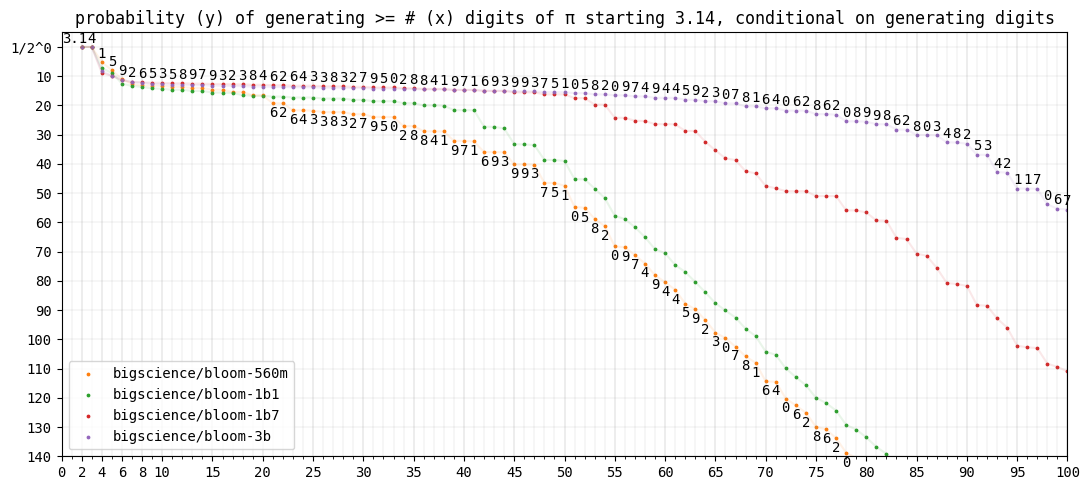

In [174]:
import matplotlib.pyplot as plt
import matplotlib

font = {'family' : 'monospace',
        'weight' : 'normal',
        'size'   : 10}

matplotlib.rc('font', **font)
matplotlib.rcParams['text.antialiased'] = True
matplotlib.rcParams['text.usetex'] = False

import numpy as np

fig, ax = plt.subplots(figsize=(11,5))

# cumul = [sum(probs[i:]) for i in range(len(probs))]

mini = 0
maxi = 100 #len(cumul)-1

ax.set_yscale("log", base=2)
# ax.set_xticks(list(q.keys())[mini:maxi])
# ax.set_xticklabels(texts[mini:maxi])#, rotation=90)

ax.set_xticks(list(range(0,10,2)) + list(range(10,200,5)), which="major")

ax.set_xticks(list(range(0,200,1)), minor=True)
# ax.set_xticklabels([], which="minor")

ax.yaxis.set_major_formatter(lambda a,b: f"1/2^{b}" if b == 0 else str(b*10))
ax.set_yticks([0.5 ** i for i in range(0, 260, 10)])

ax.grid(which='both', axis='y', visible=True, lw=0.1, c='gray')
# ax.set_xticks([], bottom=False)

ax.grid(which='major', axis='x', visible=True, lw=0.2, c='gray')
ax.grid(which='minor', axis='x', visible=True, lw=0.1, c='gray')

# fig.tight_layout()

colors = ['C1', 'C2', 'C3', 'C4']

ymin = 0.5**140

xoff = 0.0 # -0.2

ys = []

for model_name, (q, texts, probs, cumul) in ress.items():
    color = colors[0]
    colors = colors[1:]

    xs = np.array(list(q.keys())).astype(float) - 1

    xts = xs.copy()

    xts[0] = xs[0] - 0.75
    xts[1:] = xs[1:] + xoff

    ax.plot(xs[mini:maxi], cumul[mini:maxi], color=color, alpha=0.1)
    ax.scatter(xs[mini:maxi], cumul[mini:maxi], label=model_name, color=color, s=3, alpha=1.0)

    ys.append(np.array(cumul[mini:maxi]))

    if model_name in model_names[-1:]:
        for x, xt, y, t in list(zip(xs, xts, cumul, texts))[mini:maxi]:
            
            if y < ymin:
                continue

ys = np.vstack(ys)

#trans = matplotlib.transforms.Affine2D()
#trans = ax.transAxes
# trans.translate(0.1, 0.0)

from math import log

for x, y1, y2, t in list(zip(xts, ys.min(axis=0), ys.max(axis=0), texts))[mini:maxi]:
    #xt, yt = trans.transform((x, y1))
    if y2 > ymin:
        ax.annotate(t, (x, y2), xytext=(0.0, 1.0), textcoords="offset points", horizontalalignment="center", verticalalignment="bottom", color="black")#, family='monospace')
    if y1 > ymin and abs(log(y1)/log(0.5) - log(y2)/log(0.5)) > 5:
        ax.annotate(t, (x, y1), xytext=(0.0, -2.0), textcoords="offset points", horizontalalignment="center", verticalalignment="top", color="black")#, family='monospace')
        # ax.text(x=x, y=y1, s=t, horizontalalignment="center", verticalalignment="top", color="black")#, family='monospace')

        

    
    # xoff = xoff + 0.1

ax.set_ylim(ymin, 2**5)

ax.set_xlim(mini, maxi)

ax.set_title("""probability (y) of generating >= # (x) digits of π starting 3.14, conditional on generating digits""")
ax.legend(loc='lower left')

fig.tight_layout()

fig.savefig("pi.png")

In [71]:
ys.shape

(4, 10)

In [ ]:
# out = model(**tokenize("hello"))
from ipywidgets import widgets, interact
import matplotlib.pyplot as plt

ress = []

@interact(input_text=widgets.Text("Fill in the name of these NBA players: Michael", continuous_update=True))
def generate(input_text):
    global ress

    if len(input_text) == 0: return

    temp = model.forward(**tokenize(input_text))

    logits = temp['logits'][0,-1].detach().cpu()
    probits = torch.nn.functional.softmax(logits, dim=0)

    tops = torch.topk(probits, 10)

    toks = tok.batch_decode(tops.indices)

    ress = [str(toks)] + ress
    ress = ress[0:10]

    fig, ax = plt.subplots()

    ax.bar(x=range(10), height=tops.values)
    ax.set_xticks(range(len(toks)))
    ax.set_xticklabels(toks)

    for res in ress:
        print(res)